In [1]:
import numpy as np
import sys
sys.path.insert(0,'../model')
import mega
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
cm = plt.cm.get_cmap('plasma_r')

In [20]:
sims = mega.get_simulations()

def generate_fig(filename=None, latitude=50.,v_lim=[5, 8]): 
    months=[-3,0,3]
    # latitude in degrees
    # months since spring equinox
    # hours since midnight
    fig, axs = plt.subplots(3,len(months),figsize=(11,10), constrained_layout=True, squeeze=False)
    for j, month in enumerate(months):
        hours = []
        lon = mega.length_of_night(month=month, latitude=latitude, p=18)
        hours.append(-lon/2.)
        hours.append(0)
        hours.append(lon/2.)
        for i, hour in enumerate(hours):
            #print(hour,month)
            xy, mag = mega.get_stereographic_data(sims, latitude=latitude, month=month, hour=hour, airmassCoeff=0.2, randomCoeff=0.2)

            ax = axs[i][j] 
            ax.set_aspect("equal")
            r_lim = 1.02
            ax.set_xlim(-r_lim,r_lim)
            ax.set_ylim(-r_lim,r_lim)

            # hide axes
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            for s in ax.spines:
                ax.spines[s].set_visible(False)
            
            if i!=1 and hour==0:
                ax.text(0,0,"N/A",fontsize=18) 
                continue
            
                
                
            # setup labels    
            r_labels = 1.11    
            for k, d in enumerate(["N","W","S","E"]):
                ax.text(r_labels*np.sin(k*np.pi/2.),r_labels*np.cos(k*np.pi/2.)-0.02, d, ha="center", va="center",fontsize=14)
            ax.text(0.25,-1.2,"N$_{tot}$=%d"%len(xy),fontsize=18) 
            ax.text(0.25,-1.45,"N$_{vis}$=%d"%len(xy[mag<6.5]),fontsize=18) 

            # background
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=-10, color="darggray"))
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=3, edgecolor="k", facecolor="none", lw=3))

            # plot
            im=ax.scatter(xy[:,0],xy[:,1],s=4, c=mag, cmap=cm,vmin=v_lim[0],vmax=v_lim[1])
            if j==0: #time labels
                if hour==-3:
                    ax.text(-1.6,0,"9pm",verticalalignment='center',rotation='vertical',fontsize=18) 
                elif hour==0:
                    ax.text(-1.4,0,"midnight",verticalalignment='center',rotation='vertical',fontsize=18)
                elif hour==3:
                    ax.text(-1.4,0,"3am",verticalalignment='center',rotation='vertical',fontsize=18)
                elif hour<0:
                    ax.text(-1.4,0,"evening\nastronomical twilight",horizontalalignment='center',verticalalignment='center',rotation='vertical',fontsize=18)
                elif hour>0:
                    ax.text(-1.4,0,"morning\nastronomical twilight",horizontalalignment='center',verticalalignment='center',rotation='vertical',fontsize=18)    
            if i==0: #season labels
                if j==0:
                    ax.text(0,1.2,"Winter Solstice",horizontalalignment='center',fontsize=18)   
                if j==1:
                    ax.text(0,1.2,"Equinox",horizontalalignment='center',fontsize=18)
                if j==2:
                    ax.text(0,1.2,"Summer Solstice",horizontalalignment='center',fontsize=18)
    cb = fig.colorbar(im,ax=axs,shrink=1./2.)
    cb.set_label(label="Vmag",size=18)
    cb.ax.tick_params(labelsize=18)
    #cb.ax.text(0,8.5,str(int(latitude))+'$^{\circ}$N',fontsize=22,horizontalalignment='left')
    if filename is not None:
        plt.savefig(filename,facecolor='white', transparent=False,dpi=200)
        plt.close(fig)

In [18]:
generate_fig("PH_hawaii.pdf", latitude=20)
generate_fig("PH_eq.pdf", latitude=0)
generate_fig("PH_north.pdf", latitude=90)
generate_fig("PH_canada.pdf", latitude=50)

ValueError: Using a string of single character colors as a color sequence is not supported. The colors can be passed as an explicit list instead.

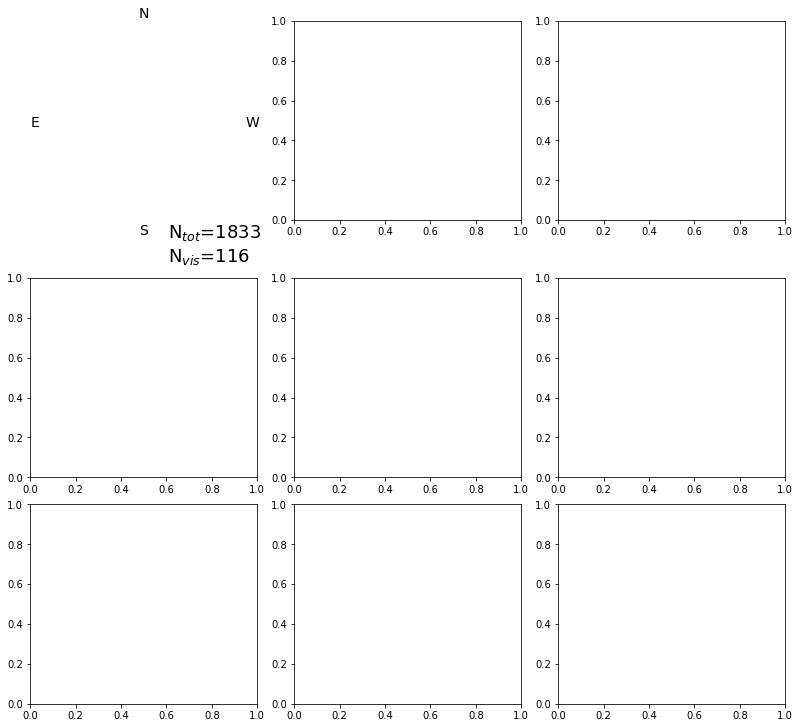

In [21]:
generate_fig(latitude=50.)